# Spectral Analysis

## Continuous-time Sine Signal

This notebook follows the section *“Continuous-time Sine Signal”* from the SciPy Signal tutorial and reproduces the `Comparison of Spectral Representations of sine signal` example. We will:

- write the time-domain signal $x(t)$ and the analytic expression for $X(f)$,
- compute several spectral representations,
- plot them for different amplitudes $a$ and durations $\tau$,
- compare analytic $X(f)$ with the FFT-based estimate,
- plot the real and imaginary parts of $X(f)$.

Reference: SciPy Signal tutorial — *Spectral Analysis*, Continuous-time Sine Signal. :contentReference[oaicite:1]{index=1}


## Mathematical definitions

Consider the windowed sine signal (Eq. (1) in SciPy):

$$
x(t) = a \sin(2\pi f_x t)\, \text{rect}\!\left(\frac{t}{\tau}-\frac{1}{2}\right)
= \left(\frac{a}{2j} e^{j 2\pi f_x t} - \frac{a}{2j} e^{-j 2\pi f_x t}\right)\text{rect}\!\left(\frac{t}{\tau}-\frac{1}{2}\right)
$$

The analytic Fourier transform of this signal can be written as:

$$
X(f) = \frac{a\tau}{2j}\Big[
  \text{sinc}\!\left(\tau(f-f_x)\right) - \text{sinc}\!\left(\tau(f+f_x)\right)
\Big] e^{-j\pi\tau f},
$$

with the normalized sinc: $\text{sinc}(u)=\dfrac{\sin(\pi u)}{\pi u}$.

From $X(f)$ we can form the representations used in the SciPy table:

- **Spectrum**: $X(f)$.
- **Amplitude Spectrum**: $X(f)/\tau$.
- **Energy Spectral Density**: $|X(f)|^2$.
- **Power Spectral Density (PSD)**: $|X(f)|^2/\tau$.
- **Amplitude Spectral Density**: $X(f)/\sqrt{\tau}$.


At $\pm f_x$ the magnitudes are (for unit V in the SciPy table):  
Spectrum: $\tfrac{1}{2}|a|\tau$, Amplitude Spectrum: $\tfrac{1}{2}|a|$, Energy: $\tfrac{1}{4}|a|^2\tau^2$, etc.

---

## Why is a sine represented as two complex exponentials?

Euler’s formula states:

$$
e^{j\theta} = \cos(\theta) + j\sin(\theta)
$$

$$
e^{-j\theta} = \cos(\theta) - j\sin(\theta)
$$

If we subtract these two:

$$
e^{j\theta} - e^{-j\theta} = 2j \sin(\theta)
$$

So:

$$
\sin(\theta) = \frac{e^{j\theta} - e^{-j\theta}}{2j}
$$

If we replace $\theta$ with $2\pi f_x t$:

$$
\sin(2\pi f_x t) = \frac{e^{j 2\pi f_x t} - e^{-j 2\pi f_x t}}{2j}
$$

**Why this matters in spectral analysis**

* The Fourier transform works very naturally with **complex exponentials** $e^{j 2\pi f t}$, because they are eigenfunctions of linear time-invariant (LTI) systems.
* Representing a sine as the sum of **two exponentials** means that in the frequency domain, a pure sine wave corresponds to **two delta spikes**:
  one at $+f_x$ (positive frequency) and one at $-f_x$ (negative frequency).
* This dual spike representation is the foundation for understanding **spectral symmetry** in real signals.



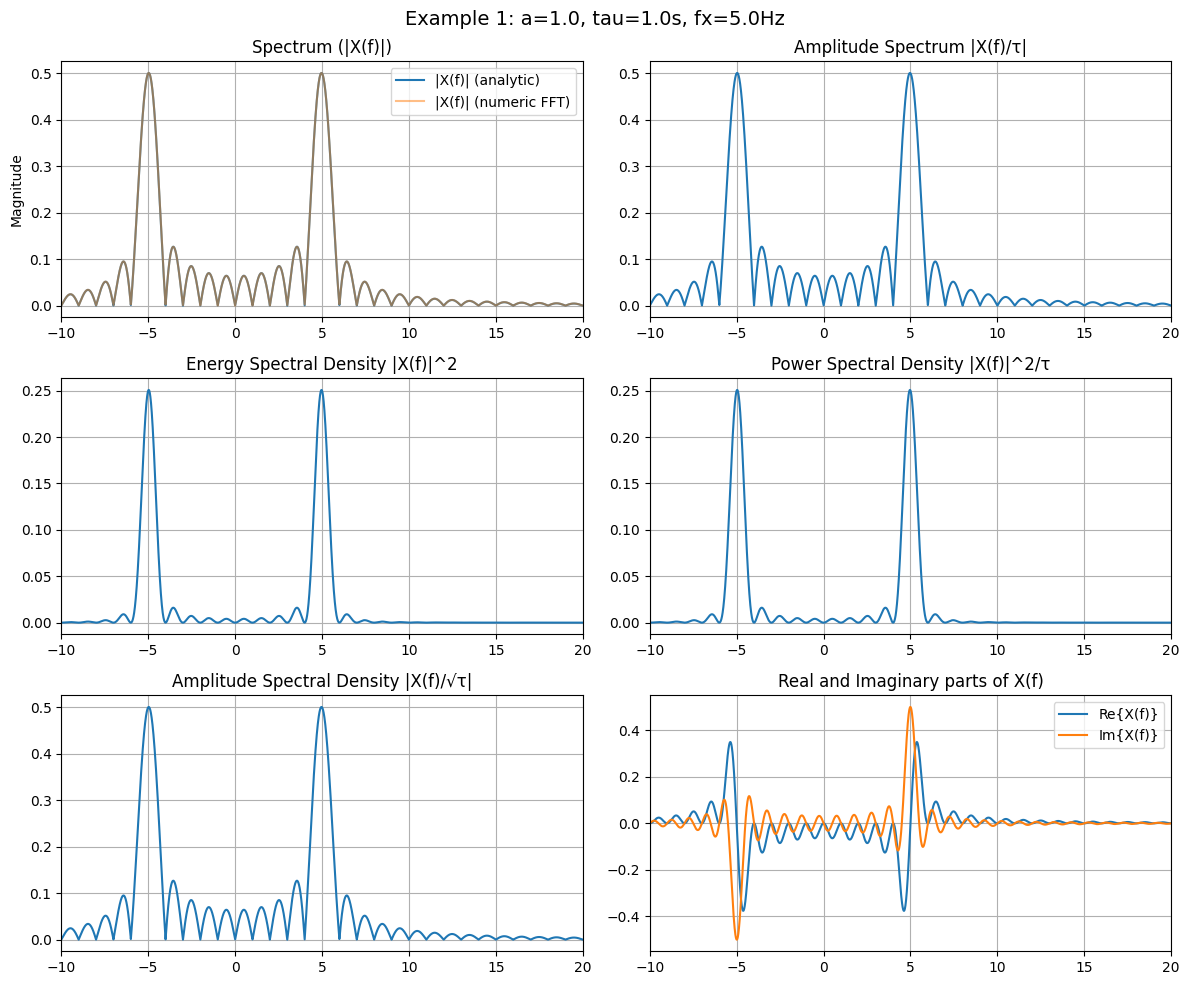

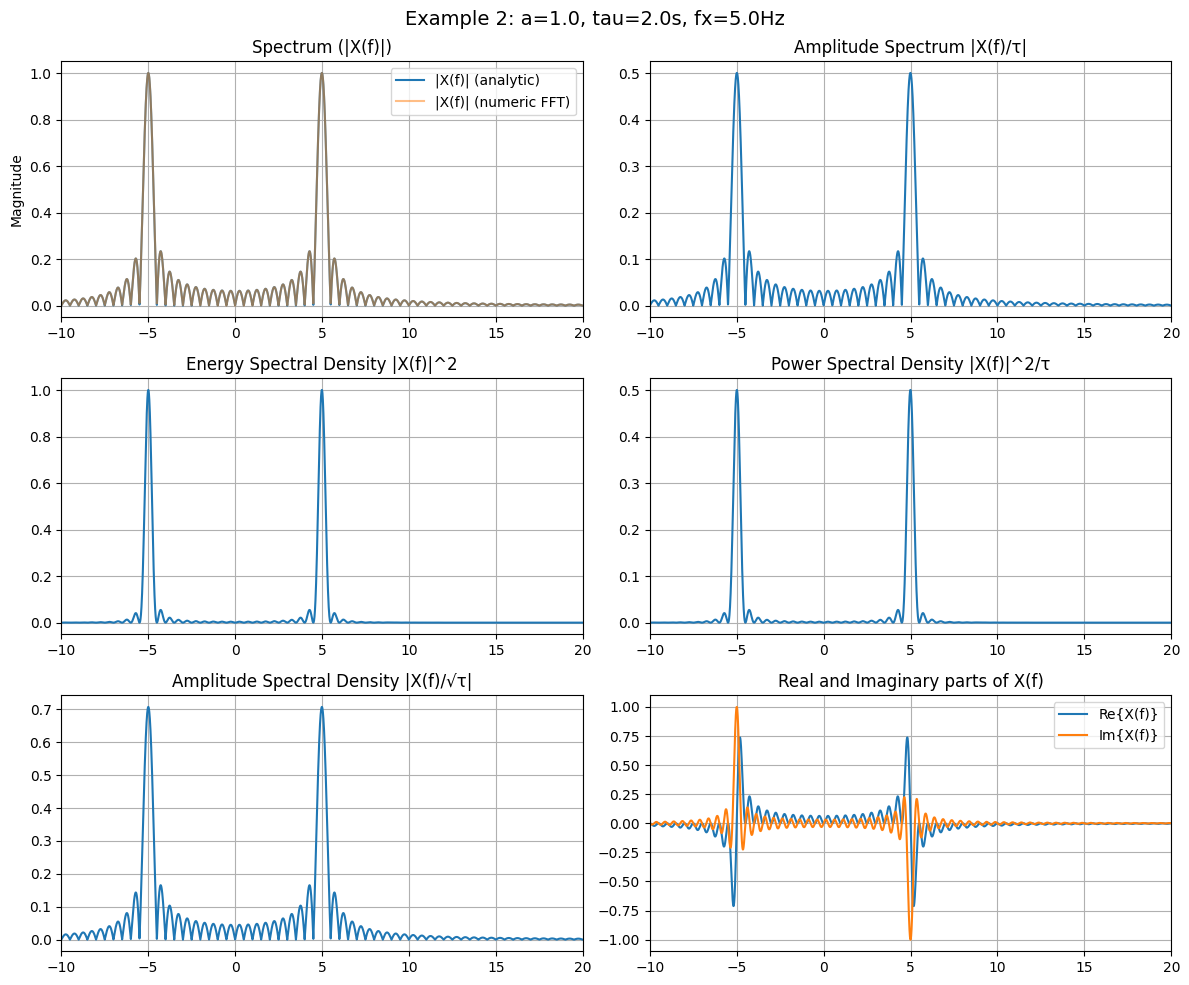

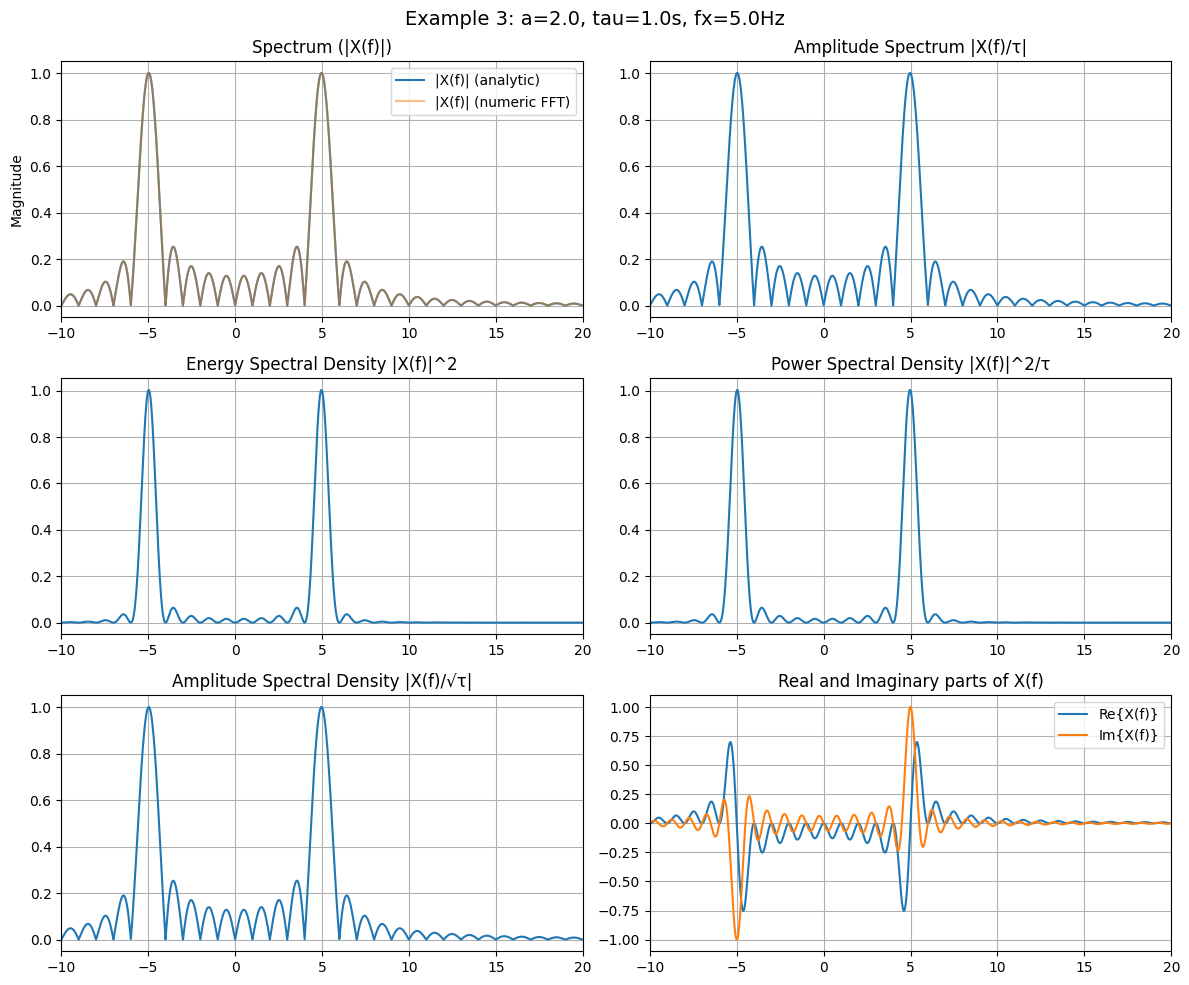

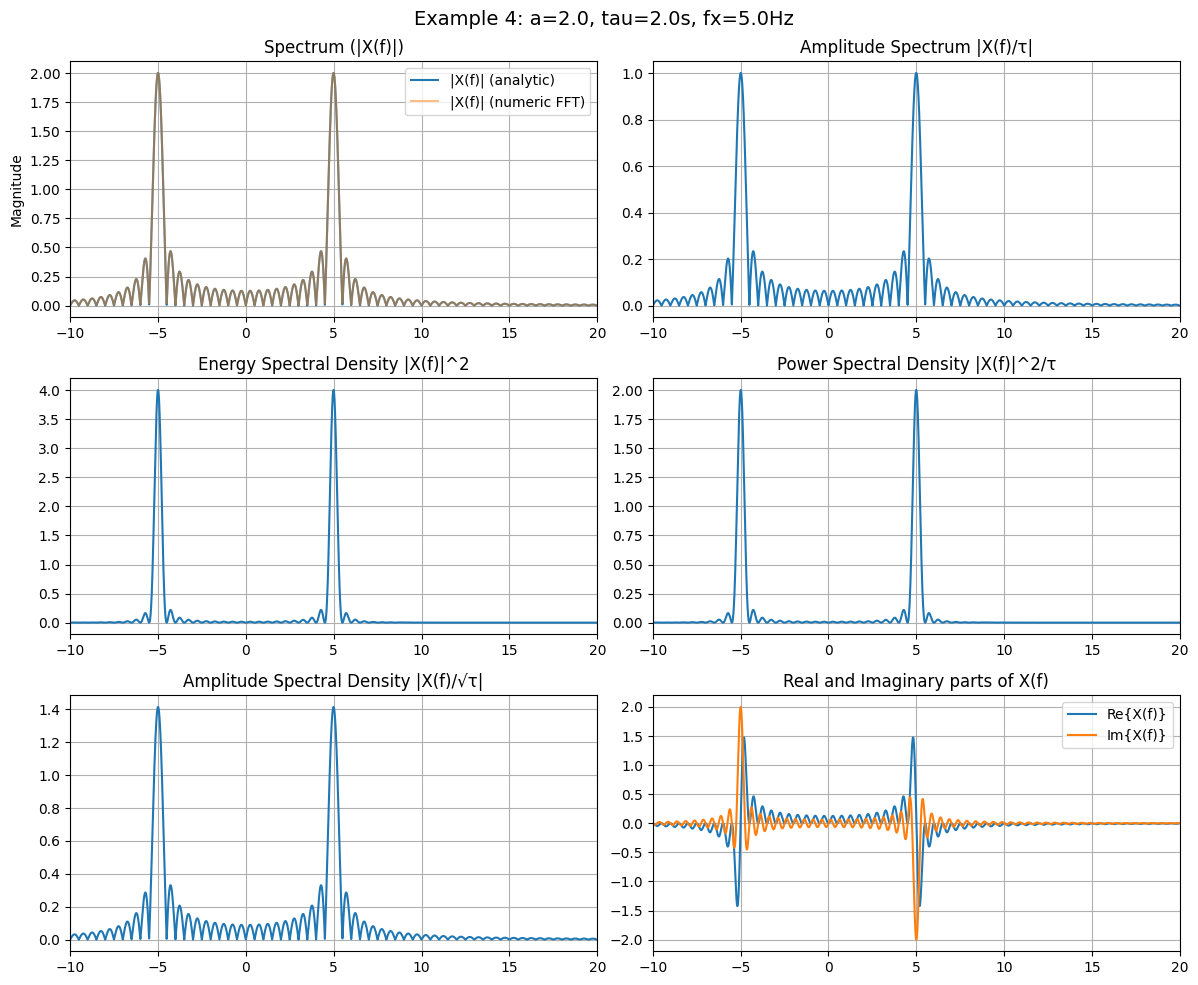

In [ ]:
# Code cell: compute analytic X(f), numerical FFT, and plot representations
import numpy as np
import matplotlib.pyplot as plt

# Parameters for plotting and signals
fs = 200.0            # sampling frequency for numeric evaluation [Hz]
nfft = 16384          # high-resolution FFT for smooth plots
f_axis = np.linspace(-50, 50, nfft)  # frequency axis for analytic X(f) and plotting

# Example sets (match SciPy example)
aa   = [1.0, 1.0, 2.0, 2.0]   # amplitudes
taus = [1.0, 2.0, 1.0, 2.0]   # durations (seconds)
f_x = 5.0                     # sine frequency [Hz] (same for all examples)

# Helper: analytic X(f) using SciPy notation
def X_analytic(f, a, tau, fx):
    # normalized sinc: numpy.sinc(x) = sin(pi x) / (pi x)
    term1 = np.sinc(tau * (f - fx))
    term2 = np.sinc(tau * (f + fx))
    Xf = (a * tau) / (2j) * (term1 - term2) * np.exp(-1j * np.pi * tau * f)
    return Xf

# To compare, build time-domain signal on a fine grid and compute FFT
def X_numeric_fft(a, tau, fx, fs, nfft):
    # time axis long enough to contain the window [0,tau)
    dt = 1.0/fs
    t = np.arange(0, tau, dt)           # samples inside [0, tau)
    x = a * np.sin(2*np.pi*fx*t)        # windowed sine since rect is 1 on [0,tau)
    # zero pad to nfft and compute FFT (centered)
    Xk = np.fft.fftshift(np.fft.fft(x, nfft))
    freqs = np.fft.fftshift(np.fft.fftfreq(nfft, d=dt))
    # normalization: if one wants the continuous-time scale multiply by dt (approx integral)
    Xk = Xk * dt
    return freqs, Xk

# Plotting: for each (a,tau) show the 5 representations side-by-side and real/imag
for idx, (a, tau) in enumerate(zip(aa, taus)):
    # analytic
    Xf = X_analytic(f_axis, a, tau, f_x)
    # numeric
    freqs_num, Xk_num = X_numeric_fft(a, tau, f_x, fs, nfft)
    
    # build representations
    Spectrum = Xf                               # complex
    AmplitudeSpectrum = Xf / tau
    EnergySD = np.abs(Xf)**2
    PSD = EnergySD / tau
    AmpSpecDens = Xf / np.sqrt(tau)
    
    # Also numeric magnitude for comparison (interpolate numeric onto f_axis if needed)
    # We'll just plot numeric using freqs_num axis
    fig, axs = plt.subplots(3, 2, figsize=(12, 10))
    fig.suptitle(f'Example {idx+1}: a={a}, tau={tau}s, fx={f_x}Hz', fontsize=14)
    
    # 1: Spectrum magnitude (|X(f)|) and numeric
    axs[0,0].plot(f_axis, np.abs(Spectrum), label='|X(f)| (analytic)')
    axs[0,0].plot(freqs_num, np.abs(Xk_num), alpha=0.5, label='|X(f)| (numeric FFT)')
    axs[0,0].set_xlim(f_x-15, f_x+15)
    axs[0,0].set_ylabel('Magnitude')
    axs[0,0].set_title('Spectrum (|X(f)|)')
    axs[0,0].legend(); axs[0,0].grid(True)
    
    # 2: Amplitude Spectrum (X(f)/tau)
    axs[0,1].plot(f_axis, np.abs(AmplitudeSpectrum))
    axs[0,1].set_xlim(f_x-15, f_x+15)
    axs[0,1].set_title('Amplitude Spectrum |X(f)/τ|')
    axs[0,1].grid(True)
    
    # 3: Energy Spectral Density |X(f)|^2
    axs[1,0].plot(f_axis, EnergySD)
    axs[1,0].set_xlim(f_x-15, f_x+15)
    axs[1,0].set_title('Energy Spectral Density |X(f)|^2')
    axs[1,0].grid(True)
    
    # 4: Power Spectral Density |X(f)|^2 / τ
    axs[1,1].plot(f_axis, PSD)
    axs[1,1].set_xlim(f_x-15, f_x+15)
    axs[1,1].set_title('Power Spectral Density |X(f)|^2/τ')
    axs[1,1].grid(True)
    
    # 5: Amplitude Spectral Density X(f)/sqrt(τ) (magnitude)
    axs[2,0].plot(f_axis, np.abs(AmpSpecDens))
    axs[2,0].set_xlim(f_x-15, f_x+15)
    axs[2,0].set_title('Amplitude Spectral Density |X(f)/√τ|')
    axs[2,0].grid(True)
    
    # 6: Real and Imag parts of X(f)
    axs[2,1].plot(f_axis, np.real(Spectrum), label='Re{X(f)}')
    axs[2,1].plot(f_axis, np.imag(Spectrum), label='Im{X(f)}')
    axs[2,1].set_xlim(f_x-15, f_x+15)
    axs[2,1].set_title('Real and Imaginary parts of X(f)')
    axs[2,1].legend(); axs[2,1].grid(True)
    
    plt.tight_layout()
    plt.show()


## Interpretation and practical notes

- **Peaks at ±$f_x$**: The analytic $X(f)$ shows two sinc-shaped lobes centered at $f=+f_x$ and $f=-f_x$, modulated by the linear phase $e^{-j\pi\tau f}$. The magnitude at the center of each lobe (spectrum) is $\tfrac{1}{2}|a|\tau$. :contentReference[oaicite:4]{index=4}

- **Different representations**:
  - The *Amplitude Spectrum* $X(f)/\tau$ normalizes by duration and shows amplitude per sample (height at $\pm f_x$ equals $\tfrac{1}{2}|a|$).
  - The *Energy Spectral Density* $|X(f)|^2$ and *PSD* $|X(f)|^2/\tau$ incorporate energy and power concepts. PSD scales with $1/\tau$.
  - The *Amplitude Spectral Density* $X(f)/\sqrt{\tau}$ gives a density with dimensions comparable to amplitude per root-Hz.

- **FFT vs analytic**: La traza numérica (FFT) debe coincidir con la expresión analítica si se usa muestreo suficientemente fino y gran `nfft`. En la práctica usamos `dt = 1/fs` pequeño y `nfft` grande para que la FFT sea fiel.

- **Effect of τ**: Increasing $\tau$ narrows the sinc main-lobe (better frequency resolution) — see examples with $\tau=1$ vs $\tau=2$. This is the classical trade-off tiempo/frecuencia.

- **Real and imaginary parts**: They reveal the phase behaviour. The linear phase factor $e^{-j\pi\tau f}$ produces characteristic sign changes across $f$, visible en las curvas Real/Imag de $X(f)$.
